In [209]:
from landsatxplore.api import API
import json
from landsatxplore.earthexplorer import EarthExplorer
import os
import pandas as pd
import glob
import tarfile
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import utm 
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
from tqdm import tqdm
from rasterio.mask import mask

username = "SimWen"
password = "..."

## 1. Find and save the data

Documentation here:
https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat8-9-Collection2-Level2-Science-Product-Guide-v5.pdf

In [27]:
# Initialize a new API instance and get an access key
api = API(username, password)

# Search for Landsat TM scenes
scenes = api.search(
    dataset='landsat_ot_c2_l2',
    latitude=51.509,
    longitude=-0.126,
    start_date='2023-04-01',
    end_date='2023-10-01',
    max_cloud_cover=10
)

print(f"{len(scenes)} scenes found")

api.logout()

5 scenes found


In [28]:
# Process the result
for scene in scenes:
    print(scene['acquisition_date'].strftime('%Y-%m-%d'))
    # Write scene footprints to disk
    fname = f"{scene['landsat_product_id']}.geojson"
    with open(fname, "w") as f:
        json.dump(scene['spatial_coverage'].__geo_interface__, f)

2023-09-15
2023-09-07
2023-09-06
2023-08-05
2023-05-26


In [29]:
df_scenes = pd.DataFrame(scenes)
df_scenes = df_scenes[['display_id','wrs_path', 'wrs_row','satellite','cloud_cover','acquisition_date']]
df_scenes.sort_values('acquisition_date', ascending=False, inplace=True)
df_scenes

,display_id,wrs_path,wrs_row,satellite,cloud_cover,acquisition_date
0,LC08_L2SP_201024_20230915_20230925_02_T1,201,24,8,3,2023-09-15
1,LC09_L2SP_201024_20230907_20230913_02_T1,201,24,9,0,2023-09-07
2,LC08_L2SP_202024_20230906_20230912_02_T1,202,24,8,7,2023-09-06
3,LC08_L2SP_202024_20230805_20230812_02_T2,202,24,8,7,2023-08-05
4,LC08_L2SP_201024_20230526_20230603_02_T1,201,24,8,6,2023-05-26


In [33]:
# Set id of selected pane
pane_id = 'LC09_L2SP_201024_20230907_20230913_02_T1'

In [31]:
# gets the scene from scenes list with display id = pane_id
pane_meta_data = next((scene for scene in scenes if scene['display_id'] == pane_id), None)

In [32]:
pane_meta_data

{'cloud_cover': 0,
 'entity_id': 'LC92010242023250LGN00',
 'display_id': 'LC09_L2SP_201024_20230907_20230913_02_T1',
 'ordering_id': 'None',
 'landsat_product_id': 'LC09_L1TP_201024_20230907_20230907_02_T1',
 'landsat_scene_id': 'LC92010242023250LGN00',
 'acquisition_date': datetime.datetime(2023, 9, 7, 0, 0),
 'collection_category': datetime.datetime(2024, 1, 1, 0, 0),
 'collection_number': 2,
 'wrs_path': 201,
 'wrs_row': 24,
 'target_wrs_path': 201,
 'target_wrs_row': 24,
 'nadir-off_nadir': 'NADIR',
 'roll_angle': -0.001,
 'date_product_generated': datetime.datetime(2023, 9, 7, 0, 0),
 'start_time': datetime.datetime(2023, 9, 7, 10, 52, 8),
 'stop_time': datetime.datetime(2023, 9, 7, 10, 52, 40),
 'station_id': 'LGN',
 'day-night_indicator': 'DAY',
 'land_cloud_cover': 0.31,
 'scene_cloud_cover': 0.26,
 'ground_control_points_model': 818,
 'ground_control_points_version': 5,
 'geometric_rmse_model': 5.952,
 'geometric_rmse_model_x': 4.157,
 'geometric_rmse_model_y': 4.26,
 'process

In [20]:
# Initialize the API
ee = EarthExplorer(username, password)

# Download the scene 
try: 
    ee.download(pane_id, output_dir='./data/raw')
    print('{} succesful'.format(pane_id))
    
# Additional error handling
except:
    if os.path.isfile('./data/raw/{}.tar'.format(pane_id)):
        print('{} error but file exists'.format(pane_id))
    else:
        print('{} error'.format(pane_id))

ee.logout()

Download failed with dataset id 1 of 3. Re-trying with the next one.
Download failed with dataset id 2 of 3. Re-trying with the next one.


100%|████████████████████████████████████████| 834M/834M [04:43<00:00, 3.08MB/s]


LC09_L2SP_201024_20230907_20230913_02_T1 succesful


In [147]:
# Extract files from tar archive
# the zipped tar file holds multiple tif (image) files of different image/product types
tar = tarfile.open(f'./data/raw/{pane_id}.tar')
tar.extractall(f'./data/raw/{pane_id}')
tar.close()

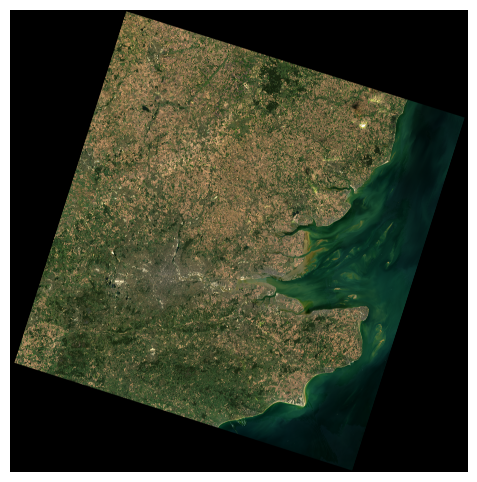

In [120]:
# Surface reflectance (SR)

# BANDS: Blue = B2, Green = B3, and Red = B4

# Load bands
Blue = tiff.imread(f'./data/raw/{pane_id}/{pane_id}_SR_B2.TIF')
Green = tiff.imread(f'./data/raw/{pane_id}/{pane_id}_SR_B3.TIF')
Red = tiff.imread(f'./data/raw/{pane_id}/{pane_id}_SR_B4.TIF')

# Stack and scale bands
# dstack stacks arrays along third dimension (i.e. (n,m) becomes (n,m,1), then bands stacked)
RGB = np.dstack((Red, Green, Blue))

# clip sets takes array (first element) and sets min and max values (2nd and 3rd elements)
RGB = np.clip(RGB*0.0000275-0.2, 0, 1)
RGB = np.clip(RGB,0,0.2)/0.2 # Clip to enhance contrast

# Display RGB image
fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(RGB)
ax.set_axis_off()

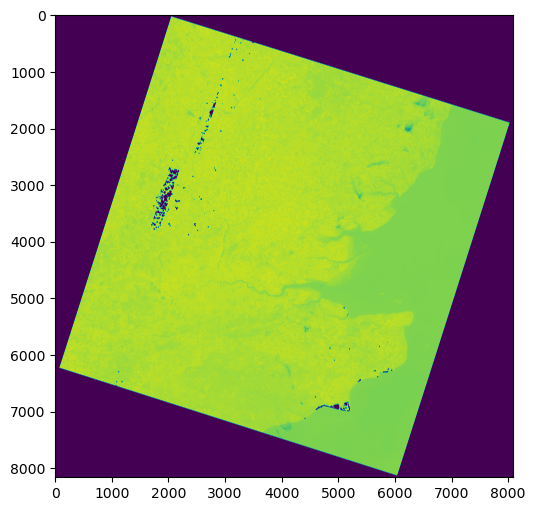

In [121]:
# Surface temperature (ST) is band B10.TIF
ST = tiff.imread(f'./data/raw/{pane_id}/{pane_id}_ST_B10.TIF')
fig, ax = plt.subplots(figsize=(6,6))
plt.imshow(ST)
#ax.set_axis_off()

## 2. Convert CRS
Landsat uses UTM coordinate reference system (crs), whereas London data uses bng or lat-longs.

Lat-longs are WGS-84 crs aka EPSG 4326, BNG are EPSG 27700.

Landsat uses the EPSG:32631 crs


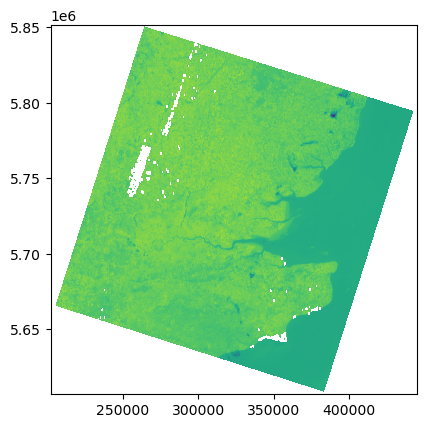

In [109]:
# First get landsat's crs
with rio.open(f'./data/raw/{pane_id}/{pane_id}_ST_B10.TIF') as src:
    landsat_crs = src.crs
    print(f'Landsat uses the {landsat_crs} crs')
    show(src)

In [115]:
def convert_crs(output_crs, output_filename):
    
    output_raster_path = f'./data/intermediate/{output_filename}.tif'

    # Open the input raster file
    with rio.open(f'./data/raw/{pane_id}/{pane_id}_ST_B10.TIF') as src:
        # Get the transform and dimensions for the reprojected raster
        transform, width, height = calculate_default_transform(
            src.crs, output_crs, src.width, src.height, *src.bounds)

        # Set up the reprojected dataset
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': output_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Create the output raster file with EPSG:4326
        with rio.open(output_raster_path, 'w', **kwargs) as dst:
            # Reproject the data from the source CRS to the target CRS
            reproject(
                source=rio.band(src, 1),
                destination=rio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=output_crs,
                resampling=Resampling.nearest)

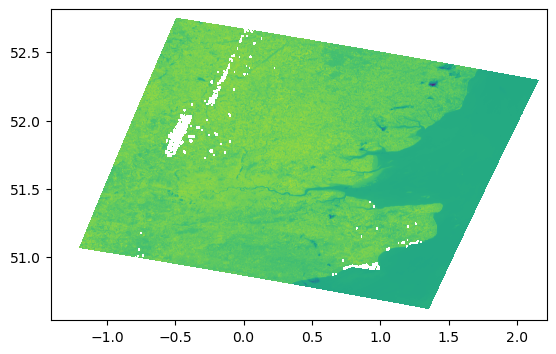

In [117]:
convert_crs(output_crs = 'EPSG:4326', output_filename = 'B10_lat_longs')
with rio.open('./data/intermediate/B10_lat_longs.tif') as src:
    show(src)

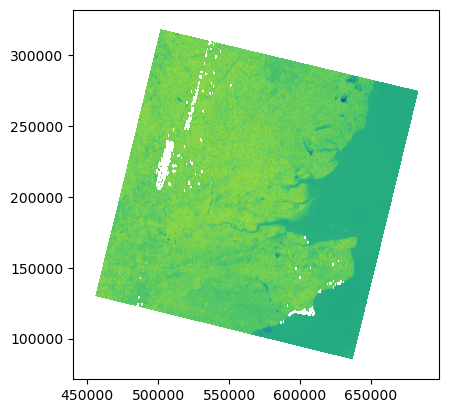

In [119]:
convert_crs(output_crs = 'EPSG:27700', output_filename = 'B10_bng')
with rio.open('./data/intermediate/B10_bng.tif') as src:
    show(src)

## 3. Crop Image to London Shapefile

### 3A. Prepare London shapefile
Crop England LSOA shapefile based on London LSOA list

In [2]:
from rasterio import mask
import geopandas as gpd

# Path to the shapefile containing the irregular polygon for London
london_boroughs_path = './data/raw/london_gis_boundaries/London_Borough_Excluding_MHW.shp'
london_boroughs = gpd.read_file(london_boroughs_path)

london_boroughs.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18..."


In [4]:
# Path to the shapefile containing the polygon for London
england_lsoas_path = './data/raw/england_lsoa_shapefiles/LSOA_2021_EW_BFC_V8.shp'
england_lsoas = gpd.read_file(england_lsoas_path)

england_lsoas.head()

,LSOA21CD,LSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,E01000001,City of London 001A,532123,181632,-0.097140,51.5182,ba0bf04c-03e6-4748-acf5-9dd1219c1860,"POLYGON ((532151.537 181867.433, 532152.500 18..."
1,E01000002,City of London 001B,532480,181715,-0.091970,51.5188,f4b205a5-5f68-4161-a014-5a2f51681597,"POLYGON ((532634.497 181926.016, 532632.048 18..."
2,E01000003,City of London 001C,532239,182033,-0.095320,51.5217,76c0a1fd-e446-4c40-9d5d-c98d689f23d5,"POLYGON ((532153.703 182165.155, 532158.250 18..."
3,E01000005,City of London 001E,533581,181283,-0.076270,51.5147,13d65a8b-5e13-443a-b355-5775794de964,"POLYGON ((533619.062 181402.364, 533639.868 18..."
4,E01000006,Barking and Dagenham 016A,544994,184274,0.089317,51.5387,06953962-0ae1-417a-8357-b314a1fb5716,"POLYGON ((545126.852 184310.838, 545145.213 18..."


In [125]:
lsoa_lookup = pd.read_csv('./data/raw/area_lookup.csv')

lsoa_lookup = lsoa_lookup[['LSOA21CD', 'LEP21NM1', 'LAD22CD', 'LAD22NM']]
lsoa_list = lsoa_lookup[lsoa_lookup['LEP21NM1'] == 'London']
lsoa_list = lsoa_list.drop_duplicates()
lsoa_list

/var/folders/xr/66lxz3_s6fg65z7bpjgp_yc80000gn/T/ipykernel_917/885822419.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  lsoa_lookup = pd.read_csv('./data/raw/area_lookup.csv')


,LSOA21CD,LEP21NM1,LAD22CD,LAD22NM
152051,E01000020,London,E09000002,Barking and Dagenham
152052,E01000022,London,E09000002,Barking and Dagenham
152053,E01034471,London,E09000002,Barking and Dagenham
152054,E01000024,London,E09000002,Barking and Dagenham
152055,E01000025,London,E09000002,Barking and Dagenham
...,...,...,...,...
178508,E01004757,London,E09000033,Westminster
178562,E01004751,London,E09000033,Westminster
178581,E01032513,London,E09000033,Westminster
178586,E01004760,London,E09000033,Westminster


In [126]:
london_lsoas_bng = pd.merge(england_lsoas, lsoa_list, on='LSOA21CD', how='left')

# Filter rows where 'LEP' is 'London'
london_lsoas_bng = london_lsoas_bng[london_lsoas_bng['LEP21NM1'] == 'London']
london_lsoas_bng.head()

,LSOA21CD,LSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,LEP21NM1,LAD22CD,LAD22NM
0,E01000001,City of London 001A,532123,181632,-0.097140,51.5182,ba0bf04c-03e6-4748-acf5-9dd1219c1860,"POLYGON ((532151.537 181867.433, 532152.500 18...",London,E09000001,City of London
1,E01000002,City of London 001B,532480,181715,-0.091970,51.5188,f4b205a5-5f68-4161-a014-5a2f51681597,"POLYGON ((532634.497 181926.016, 532632.048 18...",London,E09000001,City of London
2,E01000003,City of London 001C,532239,182033,-0.095320,51.5217,76c0a1fd-e446-4c40-9d5d-c98d689f23d5,"POLYGON ((532153.703 182165.155, 532158.250 18...",London,E09000001,City of London
3,E01000005,City of London 001E,533581,181283,-0.076270,51.5147,13d65a8b-5e13-443a-b355-5775794de964,"POLYGON ((533619.062 181402.364, 533639.868 18...",London,E09000001,City of London
4,E01000006,Barking and Dagenham 016A,544994,184274,0.089317,51.5387,06953962-0ae1-417a-8357-b314a1fb5716,"POLYGON ((545126.852 184310.838, 545145.213 18...",London,E09000002,Barking and Dagenham


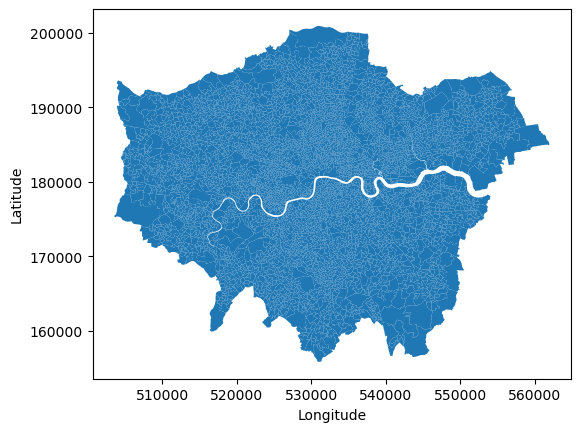

In [28]:
fig, ax = plt.subplots()
london_lsoas_bng.geometry.plot(ax=ax)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

### 3B. Crop tif to square

In [151]:
maxx = london_lsoas_bng['geometry'].bounds['maxx'].max()
maxy = london_lsoas_bng['geometry'].bounds['maxy'].max()
minx = london_lsoas_bng['geometry'].bounds['minx'].min()
miny = london_lsoas_bng['geometry'].bounds['miny'].min()

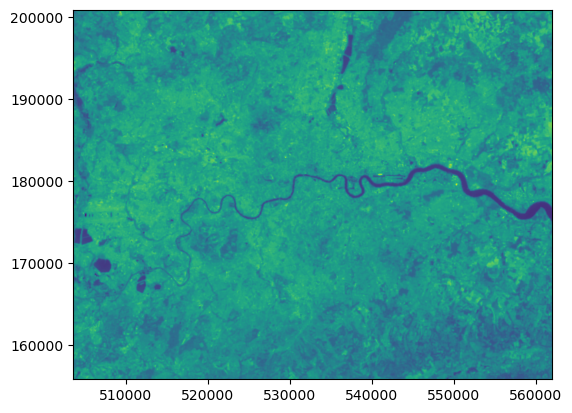

In [152]:
#minx, miny, maxx, maxy = 500000, 150000, 565000, 205000

with rio.open('./data/intermediate/B10_bng.tif') as src:
    # Get the window corresponding to the specified bounding box
    window = rio.windows.from_bounds(minx, miny, maxx, maxy, src.transform)

    # Read the data within the specified window
    cropped_data = src.read(window=window)

# Create a new rasterio DatasetReader for the cropped data
cropped_src = rio.open(
    './data/intermediate/B10_bng_cropped.tif',
    'w',
    driver='GTiff',
    width=cropped_data.shape[2],
    height=cropped_data.shape[1],
    count=src.count,
    dtype=cropped_data.dtype,
    crs=src.crs,
    transform=src.window_transform(window)
)

# Write the cropped data to the new TIFF file
cropped_src.write(cropped_data)

# Close the files
src.close()
cropped_src.close()

# Show the cropped image
with rio.open('./data/intermediate/B10_bng_cropped.tif') as cropped_src:
    show(cropped_src)
cropped_src.close()

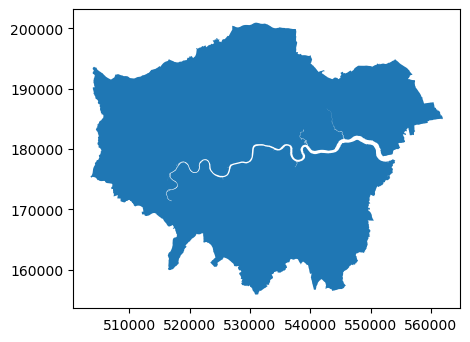

In [208]:
# collapse the GeoDataFrame based on 'LAD22NM'
london_outline_bng = london_lsoas_bng.dissolve(by='LEP21NM1')
london_outline_bng = london_outline_bng.reset_index()

fig, ax = plt.subplots(figsize=(5, 5))
london_outline_bng.geometry.plot(ax=ax)
plt.show()

In [247]:
geometry = london_outline_bng['geometry'].iloc[0]
from rasterio.mask import mask

# Open the GeoTIFF file
with rio.open('./data/intermediate/B10_bng.tif') as src:
    # Crop the raster to the polygon geometry
    cropped_data, cropped_transform = mask(src, [geometry], crop=True)
    
    cropped_data = cropped_data.astype(float)

    # Create a mask for NaN values
    nan_mask = np.isnan(cropped_data)

    # Set values outside the polygon to NaN
    cropped_data[nan_mask] = np.nan


    # Create a new rasterio DatasetReader for the cropped data
    cropped_src = rio.open(
        './data/intermediate/B10_bng_cropped2.tif',
        'w',
        driver='GTiff',
        width=cropped_data.shape[2],
        height=cropped_data.shape[1],
        count=src.count,
        dtype=cropped_data.dtype,
        crs=src.crs,
        transform=cropped_transform
    )

    # Write the cropped data to the new TIFF file
    cropped_src.write(cropped_data)

    # Close the files
    src.close()
    cropped_src.close()


### 3C. Scaling the temperature

Each pixel has an offset added and scalar multiplied to it to bring the value into the 16-bit integer range. To get the data back to its original floating point value, a scale factor and offset are provided for each band:

$$Temperature (Kelvin) = pixel digital number (DN) * scale factor + offset$$

See here: https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products

In [231]:
scale_factor = 0.00341802
add_offset = 149
kelvin_to_celsius = -273.15

def scale_to_celcius(tif_name, plot = False):
    with rio.open(f'./data/intermediate/{tif_name}.tif') as cropped_src:

        # Read the surface temperature data (DN values)
        temperature_data_dn = cropped_src.read(1)

        # Convert DN to temperature in degrees Celsius
        temperature_data_celsius = (temperature_data_dn * scale_factor) + add_offset + kelvin_to_celsius
        
        if plot == True:
            # Show the plot with temperature in degrees Celsius
            plot = show(temperature_data_celsius, transform=cropped_src.transform, cmap='viridis', ax=plt.gca(), vmin=18)

            # Add a colorbar
            colorbar = plot.get_figure().colorbar(plot.get_images()[0], ax=plot.axes, orientation='vertical', pad=0.02)
            colorbar.set_label('Temperature (°C)')

            # Show the plot
            plt.show()
    
    with rio.open(f'./data/intermediate/{tif_name}.tif') as cropped_src:

        metadata = cropped_src.meta.copy()
        # Update the data type to float32 for temperature values
        metadata['dtype'] = 'float32'

        # Open the new file for writing
        with rio.open(f'./data/intermediate/{tif_name}_celcius.tif', 'w', **metadata) as dst:
            # Write the corrected temperature data to the new file
            dst.write(temperature_data_celsius, 1)

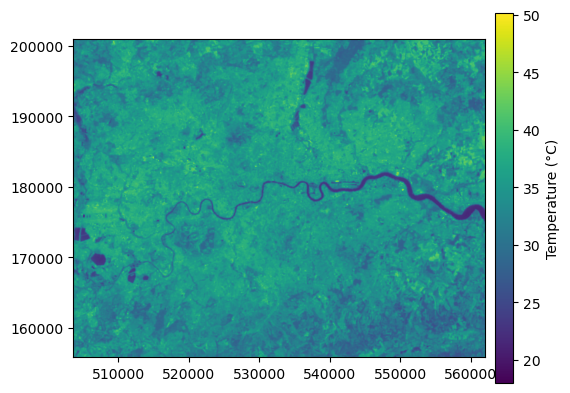

In [232]:
scale_to_celcius(tif_name = 'B10_bng_cropped', plot = True)

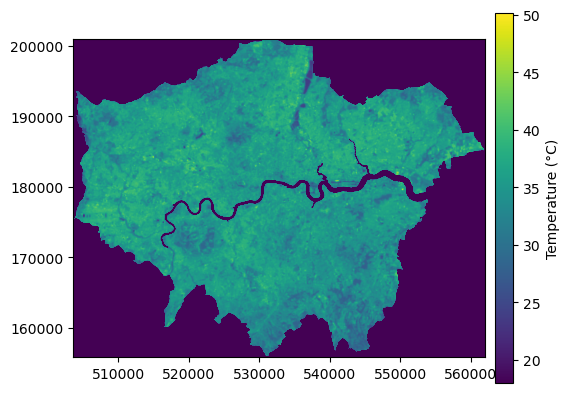

In [233]:
scale_to_celcius(tif_name = 'B10_bng_cropped2', plot = True)

## 4. Calculate average temperature

### 4A. Create dataset of pixel coordinates and temperatures

In [255]:
with rio.open('./data/intermediate/B10_bng_cropped_celcius.tif') as src_celcius:
    
    # Read the raster data
    raster_data = src_celcius.read(1)  # Assuming a single-band raster

    # Get the transformation information (georeferencing)
    transform = src_celcius.transform

# Get the width and height of the raster
width = raster_data.shape[1]
height = raster_data.shape[0]

# Get the coordinates of the pixel centers
x_coords, y_coords = zip(*[transform * (i + 0.5, j + 0.5) for i in range(width) for j in range(height)])

# Flatten the raster values
pixel_values = raster_data.flatten()

# Create DataFrame
london_temps = pd.DataFrame({'Pixel_Value': pixel_values, 'longitude': x_coords, 'latitude': y_coords})

# Convert to a GeoDataFrame
geometry_london_temps = [Point(xy) for xy in zip(london_temps['longitude'], london_temps['latitude'])]
gdf_london_temps = gpd.GeoDataFrame(london_temps, geometry=gpd.GeoSeries(geometry_london_temps))

gdf_london_temps.head()

,Pixel_Value,longitude,latitude,geometry
0,31.855268,503583.094084,200918.890916,POINT (503583.094 200918.891)
1,31.554483,503583.094084,200888.890748,POINT (503583.094 200888.891)
2,31.506630,503583.094084,200858.890581,POINT (503583.094 200858.891)
3,31.616007,503583.094084,200828.890413,POINT (503583.094 200828.890)
4,31.089632,503583.094084,200798.890245,POINT (503583.094 200798.890)


### 4B. Average temperature by LAD

In [249]:
# collapse the GeoDataFrame based on 'LAD22NM'
london_lads_bng = london_lsoas_bng.dissolve(by='LAD22NM')
london_lads_bng = london_lads_bng.reset_index()

london_lads_bng.tail(3)

,LAD22NM,geometry,level_0,index,LSOA21CD,LSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,LEP21NM1,LAD22CD
30,Waltham Forest,"POLYGON ((536642.063 186557.922, 536639.812 18...",4093,4093,E01004327,Waltham Forest 028A,539666,186305,0.01335,51.5583,7f25935f-a4c9-474a-a81b-d46de0276bed,London,E09000031
31,Wandsworth,"POLYGON ((524277.249 172491.974, 524269.500 17...",4235,4235,E01004472,Wandsworth 021A,528563,173835,-0.15126,51.4489,f668a646-8788-4f6f-a3c7-6f2780cada55,London,E09000032
32,Westminster,"POLYGON ((525844.954 180583.864, 525822.862 18...",4403,4403,E01004646,Westminster 002A,526297,183587,-0.18036,51.5371,5dec932e-8e48-469e-a14c-3ea2caf62cfb,London,E09000033


In [257]:
# Calculate average temperature by LAD 
avg_temp_list = []

progress_bar = tqdm(total=len(london_lads_bng), desc="Calculating avg LAD temp")

for index, polygon in london_lads_bng.iterrows():
    # creates boolean mask for if points in gdf_london_temps are within the each london_lsoas_bng polygon
    mask = gdf_london_temps.within(polygon['geometry'])
    # calculates average pixel value (temp) where mask is true 
    avg_temp = gdf_london_temps.loc[mask, 'Pixel_Value'].mean()
    avg_temp_list.append(avg_temp)
    
    # Update the progress bar
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Add the average temp values to df1
london_lads_bng.loc[:, 'avg_temp'] =avg_temp_list

Calculating avg LAD temp: 100%|█████████████████| 33/33 [33:29<00:00, 60.90s/it]


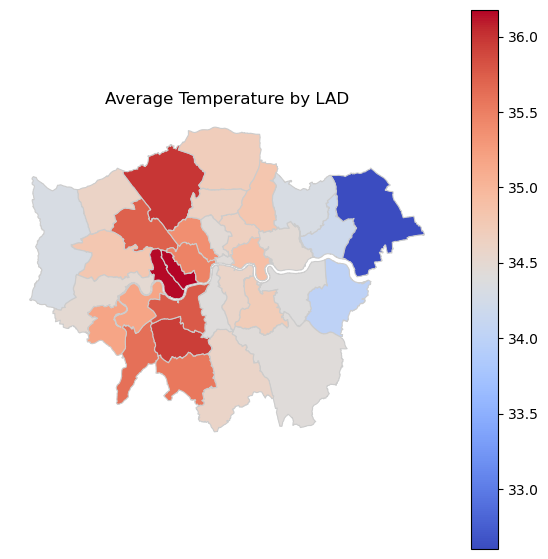

In [260]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
london_lads_bng.plot(column='avg_temp', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Customize the plot
ax.set_title('Average Temperature by LAD')
ax.set_axis_off()

# Show the plot
plt.show()

### 4C. Average temperature by LSOA

In [262]:
# Calculate average temperature by LSOA 
avg_temp_list = []

progress_bar = tqdm(total=len(london_lsoas_bng), desc="Calculating avg LSOA temp")

for index, polygon in london_lsoas_bng.iterrows():
    # creates boolean mask for if points in gdf_london_temps are within the each london_lsoas_bng polygon
    mask = gdf_london_temps.within(polygon['geometry'])
    # calculates average pixel value (temp) where mask is true 
    avg_temp = gdf_london_temps.loc[mask, 'Pixel_Value'].mean()
    avg_temp_list.append(avg_temp)
    
    # Update the progress bar
    progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Add the average temp values to df1
london_lsoas_bng.loc[:, 'avg_temp'] = avg_temp_list

Calculating avg LSOA temp: 100%|█████████| 4994/4994 [17:44:25<00:00, 12.79s/it]


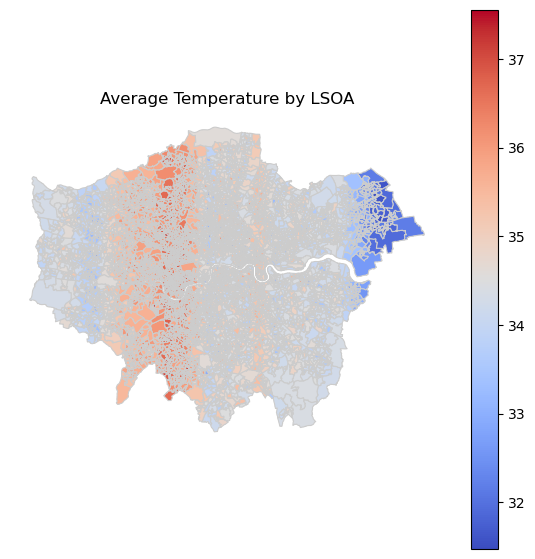

In [263]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
london_lsoas_bng.plot(column='avg_temp', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Customize the plot
ax.set_title('Average Temperature by LSOA')
ax.set_axis_off()

# Show the plot
plt.show()